# Chapter 4. Exploratory Data Analysis for Finance

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Basic patterns for processing raw financial data

### Data importing and structuring DataFrame

In [163]:
import os
# Directory where your CSV files are stored
# data_dir = "./data_folder" # for Unix-based operation systems
# data_dir = r"C:\path\to\your\data_folder" # for Windows
# data_dir = ".\\"  # Current folder for Windows-based operating systems
data_dir = "."    # Current for Unix-based operation systems
# Get list of all files in the directory
# all_files = os.listdir(data_dir)
all_files = os.listdir() # from current location
# Filter out the action and OHLC files
action_files = [f for f in all_files if '_actions.csv' in f]
ohlc_files = [f for f in all_files if '_ohlc.csv' in f]
# Extract tickers from file names
tickers_from_actions_files = set(f.split('_')[0] for f in action_files)
tickers_from_ohlc_files = set(f.split('_')[0] for f in ohlc_files)
# Find tickers that are in both sets (intersection)
common_tickers = tickers_from_actions_files & tickers_from_ohlc_files
# Find tickers that are only in the second set (difference)
tickers_only_in_ohlc = tickers_from_ohlc_files - tickers_from_actions_files
# Find tickers that are in either set (union)
all_tickers = tickers_from_actions_files | tickers_from_ohlc_files

In [164]:
# Initialize final DataFrame
final_df = pd.DataFrame()
# Loop through tickers common to both action and ohlc files
for ticker in common_tickers:
    # Load and filter action data
    action_df = pd.read_csv(f"{data_dir}/{ticker}_actions.csv", parse_dates=['Date'], index_col='Date')
    action_df = action_df[['Dividends','Stock Splits']]
    action_df.rename(columns={'Dividends': f"{ticker}_div", 'Stock Splits': f"{ticker}_split"}, inplace=True)
    # Load and filter ohlc data
    ohlc_df = pd.read_csv(f"{data_dir}/{ticker}_ohlc.csv", parse_dates=['Date'], index_col='Date')
    ohlc_df = ohlc_df[['close','volume']]
    ohlc_df.rename(columns={'close': f"{ticker}_close", 'volume': f"{ticker}_volume"}, inplace=True)
    # Merge action and ohlc data
    merged_df = action_df.join(ohlc_df, how='outer')
    # Update final DataFrame
    final_df = merged_df if final_df.empty else final_df.join(merged_df, how='outer')

# Loop through tickers only in ohlc files
for ticker in tickers_only_in_ohlc:
    # Load and filter ohlc data
    ohlc_df = pd.read_csv(f"{data_dir}/{ticker}_ohlc.csv", parse_dates=['Date'], index_col='Date')
    ohlc_df = ohlc_df[['Close','Volume']]
    ohlc_df.rename(columns={'Close': f"{ticker}_close", 'Volume': f"{ticker}_volume"}, inplace=True)

    # Update final DataFrame
    final_df = ohlc_df if final_df.empty else final_df.join(ohlc_df, how='outer')

In [165]:
# Display the first 5 rows of the final DataFrame to get an overview of the data
print(final_df.head())
# Display the first 5 rows of columns containing 'close' in their names (e.g., stock closing prices)
print(final_df.filter(like='close').head())
# Display the first 5 rows of columns containing 'volume' in their names (e.g., stock trading volumes)
print(final_df.filter(like='volume').head())
# Display the first 5 rows of columns related to TSLA (Tesla, Inc.)
print(final_df.filter(like='TSLA').head())

            XOM_div  XOM_split  XOM_close  XOM_volume  TSLA_div  TSLA_split  \
Date                                                                          
2022-01-01      NaN        NaN        NaN         NaN       NaN         NaN   
2022-01-02      NaN        NaN        NaN         NaN       NaN         NaN   
2022-01-03      0.0        0.0  63.540001  24282400.0       0.0         0.0   
2022-01-04      0.0        0.0  65.930000  38584000.0       0.0         0.0   
2022-01-05      0.0        0.0  66.750000  34033300.0       0.0         0.0   

            TSLA_close  TSLA_volume  AAPL_div  AAPL_split  ...  GS_div  \
Date                                                       ...           
2022-01-01         NaN          NaN       NaN         NaN  ...     NaN   
2022-01-02         NaN          NaN       NaN         NaN  ...     NaN   
2022-01-03     1199.78   34895349.0       0.0         0.0  ...     0.0   
2022-01-04     1149.59   33416086.0       0.0         0.0  ...     0.0   
20

### Elementary data-clearing patters

In [166]:
# ETL Pattern: Inspect the Data Frame
# Display the data types and non-null counts for each column
print("Initial DataFrame Info:")
print(final_df.info())
# Display the number of rows and columns in the DataFrame
print("Initial DataFrame Shape (Rows, Columns):", final_df.shape)
# Display the first 5 rows of the DataFrame
print("First 5 Rows of Initial DataFrame:")
print(final_df.head())
# Display the last 5 rows of the DataFrame
print("Last 5 Rows of Initial DataFrame:")
print(final_df.tail())

# ETL Pattern: Data Sorting
# Sort the DataFrame by index (Date) in ascending order
final_df.sort_index(inplace=True)

# ETL Pattern: Data Cleaning
# Check for NaN values in each column and display the sum
print("\nNumber of NaN Values in Each Column:")
print(final_df.isna().sum())
# Check for duplicate rows and display them
print("Duplicate Rows in DataFrame:")
print(final_df[final_df.duplicated()])
# Drop all duplicate rows from the DataFrame
final_df.drop_duplicates(inplace=True)
# For Sunday and Monday (non-business days), use Friday's data
# Forward-fill missing values for every day by the last valid observation
final_df = final_df.ffill()
print()
# Drop remaining NaN values from the DataFrame
final_df.dropna(inplace=True)
# Confirm that there are no more NaN values
print("Number of NaN Values After Cleaning:")
print(final_df.isna().sum())
# Identify columns to change data types
volume_cols = [col for col in final_df.columns if '_volume' in col]
close_cols = [col for col in final_df.columns if '_close' in col]
split_cols = [col for col in final_df.columns if '_split' in col]
# Change data types for volume columns to int64 and close columns to float64
final_df[volume_cols] = final_df[volume_cols].astype('int64')
final_df[close_cols] = final_df[close_cols].astype('float64')
final_df[split_cols] = final_df[split_cols].astype('int32')

# Inspect the DataFrame after all transformations
print("\nFinal DataFrame Info:")
print(final_df.info())
# Display the first 5 rows of the final DataFrame
print("\nFirst 5 Rows of Final DataFrame:")
print(final_df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 660 entries, 2022-01-01 to 2023-10-22
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   XOM_div         453 non-null    float64
 1   XOM_split       453 non-null    float64
 2   XOM_close       453 non-null    float64
 3   XOM_volume      453 non-null    float64
 4   TSLA_div        453 non-null    float64
 5   TSLA_split      453 non-null    float64
 6   TSLA_close      453 non-null    float64
 7   TSLA_volume     453 non-null    float64
 8   AAPL_div        453 non-null    float64
 9   AAPL_split      453 non-null    float64
 10  AAPL_close      453 non-null    float64
 11  AAPL_volume     453 non-null    float64
 12  AMZN_div        453 non-null    float64
 13  AMZN_split      453 non-null    float64
 14  AMZN_close      453 non-null    float64
 15  AMZN_volume     453 non-null    float64
 16  GS_div          453 non-null    float

### Transforming data

In [167]:
# ETL Pattern: Data Transformation
# Loop through each common ticker to correct share price and volume for stock splits
for ticker in common_tickers:
  # Create a new column to hold non-zero split values, replacing zeros with ones
  final_df[f"{ticker}_split1"] = final_df[f"{ticker}_split"]
  final_df[f"{ticker}_split1"].replace(0, 1, inplace=True)
  # Calculate the cumulative product of the split factor
  final_df[f"{ticker}_split1"] = final_df[f"{ticker}_split1"].cumprod()
  # Normalize the split factor
  final_df[f"{ticker}_split1"] = final_df[f"{ticker}_split1"].max() / final_df[f"{ticker}_split1"]
  # Correct the close price by dividing it by the normalized split factor
  final_df[f"{ticker}_close"] = final_df[f"{ticker}_close"] / final_df[f"{ticker}_split1"]
  # Correct the volume by multiplying it by the normalized split factor
  final_df[f"{ticker}_volume"] = final_df[f"{ticker}_volume"] * final_df[f"{ticker}_split1"]
  # Drop the temporary column used for split normalization
  final_df.drop(f"{ticker}_split1", axis=1, inplace=True)
# Display the head and tail of the DataFrame filtered for 'AMZN' as an example
print(final_df.filter(like='AMZN').head())
print(final_df.filter(like='AMZN').tail())

# Calculate the Rate of Return (RoR) for all tickers
for ticker in all_tickers:
  final_df[f"{ticker}_rate"] = final_df[f"{ticker}_close"].pct_change()
# Drop any rows with NaN values
final_df.dropna(inplace=True)
# Display the head of the DataFrame to inspect the first few rows
print("Data with RoR values\n", final_df.head())

            AMZN_div  AMZN_split  AMZN_close  AMZN_volume
Date                                                     
2022-01-03       0.0           0    170.4045   63869140.0
2022-01-04       0.0           0    167.5220   70725160.0
2022-01-05       0.0           0    164.3570   64302720.0
2022-01-06       0.0           0    163.2540   51957780.0
2022-01-07       0.0           0    162.5540   46605900.0
            AMZN_div  AMZN_split  AMZN_close  AMZN_volume
Date                                                     
2023-10-18       0.0           0      128.13   42699479.0
2023-10-19       0.0           0      128.40   60961355.0
2023-10-20       0.0           0      125.17   56406410.0
2023-10-21       0.0           0      125.17   56406410.0
2023-10-22       0.0           0      125.17   56406410.0
Data with RoR values
             XOM_div  XOM_split  XOM_close  XOM_volume  TSLA_div  TSLA_split  \
Date                                                                          
2022-01-

/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_23618/941600252.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df[f"{ticker}_split1"].replace(0, 1, inplace=True)
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_23618/941600252.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [168]:
# ETL Pattern: Data Aggregation
# Group by month
df_pct_monthly = final_df.filter(like='rate').resample('M').apply(lambda x: x.mean() * x.count())
# Assuming final_df has a DateTime index
df_pct_monthly.index = df_pct_monthly.index.strftime('%Y-%m')
print("Group by month data\n", df_pct_monthly.head())

Group by month data
          BTC-USD_rate  XOM_rate  TSLA_rate  AAPL_rate  AMZN_rate   GS_rate  \
Date                                                                         
2022-01     -0.176673  0.181564  -0.225129  -0.036327  -0.124930 -0.103653   
2022-02      0.142166  0.035855  -0.059767  -0.054720   0.041404 -0.035976   
2022-03      0.068900  0.060255   0.229130   0.060313   0.067145 -0.029531   
2022-04     -0.178505  0.035199  -0.196009  -0.097564  -0.253446 -0.073664   
2022-05     -0.144366  0.125199  -0.106458  -0.047672  -0.019532  0.071233   

         JNJ_rate  
Date               
2022-01  0.005265  
2022-02 -0.043784  
2022-03  0.075528  
2022-04  0.019761  
2022-05 -0.004094  


/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_23618/2796458124.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_pct_monthly = final_df.filter(like='rate').resample('M').apply(lambda x: x.mean() * x.count())


## Exploring the basics of EDA for financial analysis

### Descreptive statistics

In [169]:
final_df.filter(like='close')

,XOM_close,TSLA_close,AAPL_close,AMZN_close,GS_close,JNJ_close,BTC-USD_close
Date,,,,,,,
2022-01-04,65.930000,383.196667,179.70,167.522,407.48,171.08,45897.574219
2022-01-05,66.750000,362.706667,174.92,164.357,398.63,172.22,43569.003906
2022-01-06,68.320000,354.900000,172.00,163.254,396.93,171.63,43160.929688
2022-01-07,68.879997,342.320000,172.17,162.554,397.51,173.95,41557.902344
2022-01-08,68.879997,342.320000,172.17,162.554,397.51,173.95,41733.941406
...,...,...,...,...,...,...,...
2023-10-18,112.949997,242.680000,175.84,128.130,301.96,152.73,28328.341797
2023-10-19,113.019997,220.110000,175.46,128.400,299.19,152.32,28719.806641
2023-10-20,111.080002,211.990000,172.88,125.170,300.05,153.00,29682.949219


In [170]:
(final_df.filter(like='close').iloc[:, 0] * final_df.filter(like='volume').iloc[:, 0]).sum() / final_df.filter(like='volume').sum()


XOM_volume         96.785315
TSLA_volume        18.691174
AAPL_volume        27.087475
AMZN_volume        29.320989
GS_volume         818.835487
JNJ_volume        226.374365
BTC-USD_volume      0.085892
dtype: float64

In [171]:
final_df.filter(like='close').columns.get_loc('BTC-USD_close')

6

In [172]:
def generate_descriptive_stats(stat_data, w_data=None):
    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame()
    # Calculate and store each statistic
    result_df['Mean'] = stat_data.mean()
    result_df['Median'] = stat_data.median()
    result_df['SD'] = stat_data.std()
    result_df['Var'] = stat_data.var()
    result_df['CV'] = (stat_data.std() / stat_data.mean()) * 100
    # Calculate the weighted means for all columns if w_data is provided
    if w_data is not None:
        w_means = []
        for col in stat_data.columns:
            w_col = w_data.columns[stat_data.columns.get_loc(col)]
            w_mean = (stat_data[col] * 
                      w_data[w_col]).sum() / w_data[w_col].sum()
            w_means.append(w_mean)
        result_df['Weighted_Mean'] = w_means
    return result_df
# Filter data for 'close' and 'volume'
stat_data_close = final_df.filter(like='close')
w_data = final_df.filter(like='volume')
# Generate descriptive statistics for asset prices
result_close = generate_descriptive_stats(stat_data_close, w_data)
# Display the results
print("Descriptive Statistics for close prices:\n", result_close)
# Generate descriptive statistics for RoR
print("\nDescriptive Statistics for 'RoR':\n",
      generate_descriptive_stats(final_df.filter(like='rate')))

Descriptive Statistics for close prices:
                        Mean        Median           SD           Var  \
XOM_close         99.923546    104.160004    12.837336  1.647972e+02   
TSLA_close       239.846969    244.666667    57.278358  3.280810e+03   
AAPL_close       161.037139    162.410000    16.637431  2.768041e+02   
AMZN_close       121.359139    122.280000    21.400457  4.579796e+02   
GS_close         334.381324    331.480000    23.985858  5.753214e+02   
JNJ_close        167.962374    167.710000     8.046566  6.474723e+01   
BTC-USD_close  27336.534981  26664.550781  7829.312808  6.129814e+07   

                      CV  Weighted_Mean  
XOM_close      12.847159      96.785315  
TSLA_close     23.881210     226.746149  
AAPL_close     10.331425     159.019770  
AMZN_close     17.633989     120.340881  
GS_close        7.173205     334.538805  
JNJ_close       4.790696     168.123664  
BTC-USD_close  28.640473   27129.036136  

Descriptive Statistics for 'RoR':
          

In [173]:
print("Descriptive Statistics for monthly RoR data:\n",
      generate_descriptive_stats(df_pct_monthly))


Descriptive Statistics for monthly RoR data:
                   Mean    Median        SD       Var           CV
BTC-USD_rate -0.007358 -0.003149  0.168895  0.028526 -2295.247467
XOM_rate      0.029447  0.035527  0.090655  0.008218   307.857288
TSLA_rate    -0.013182 -0.044623  0.200651  0.040261 -1522.194315
AAPL_rate     0.001347 -0.008049  0.084180  0.007086  6250.288806
AMZN_rate    -0.006241 -0.016250  0.119432  0.014264 -1913.796975
GS_rate      -0.009556 -0.032753  0.085080  0.007239  -890.365361
JNJ_rate     -0.004004 -0.005591  0.044972  0.002022 -1123.271556


### Basic Statistical Data Visualization

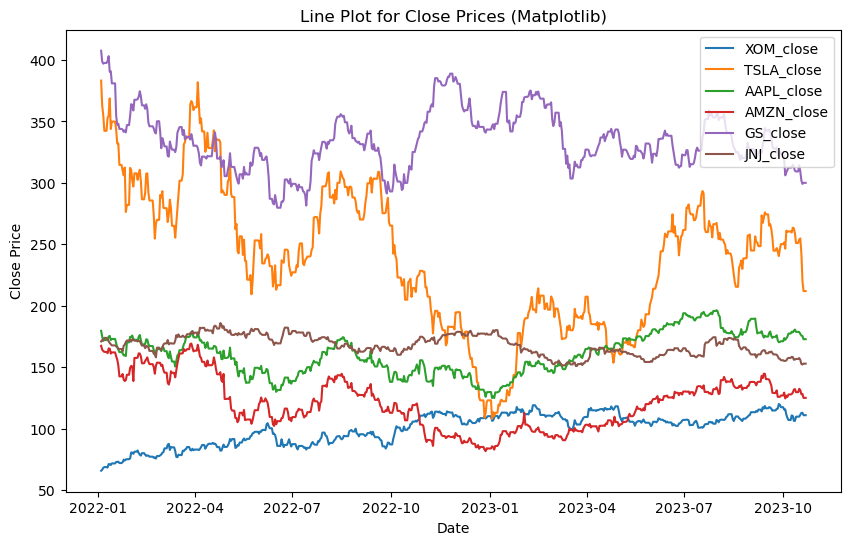

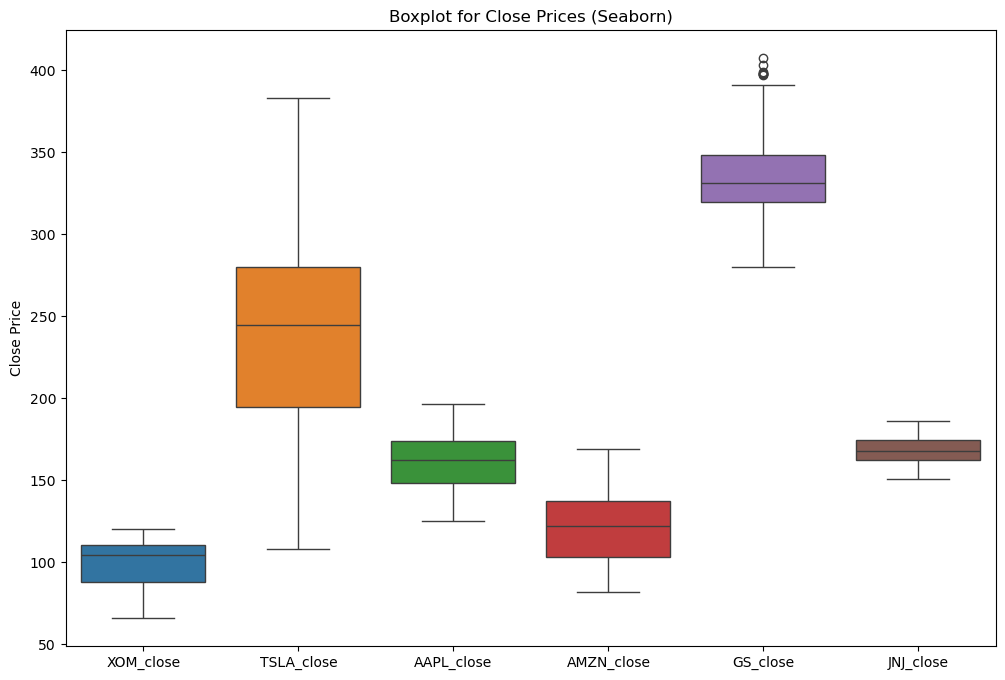

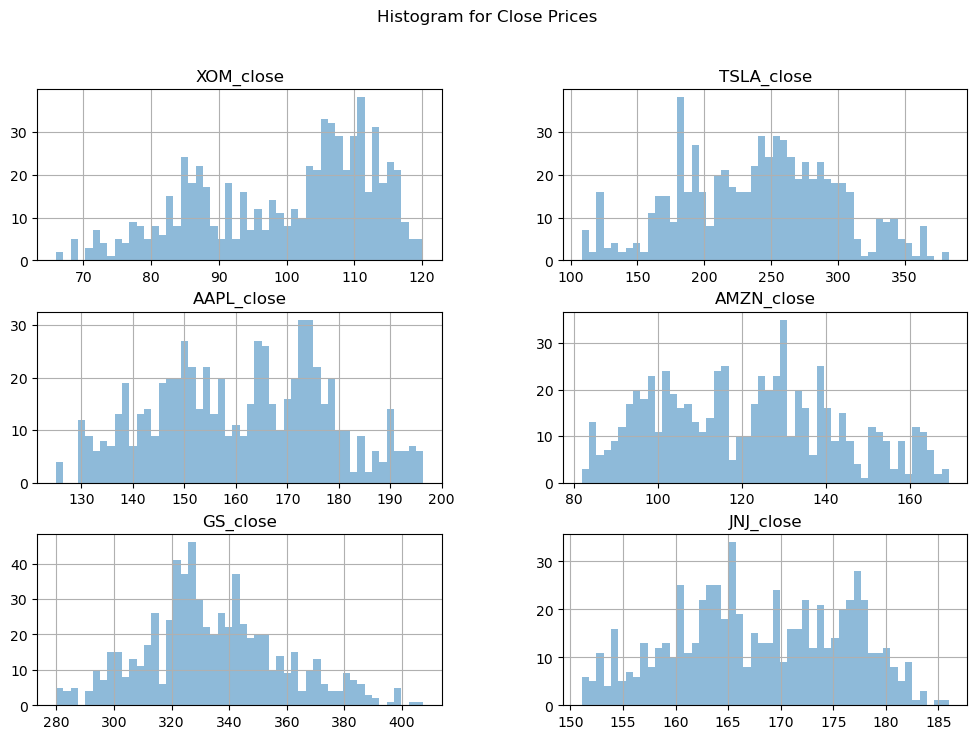

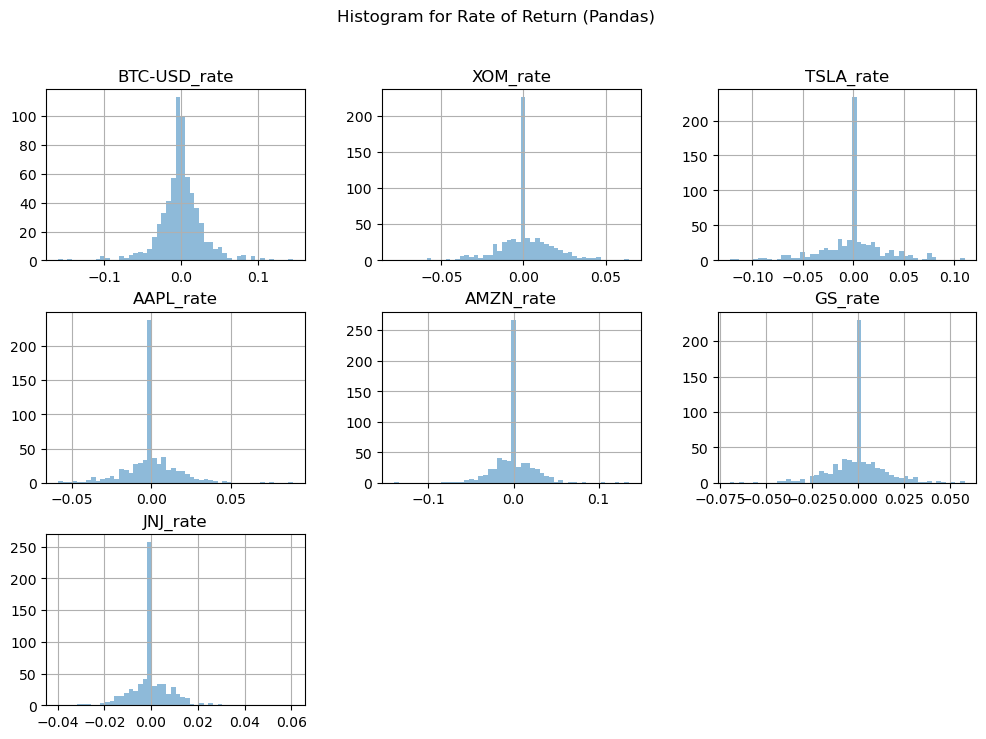

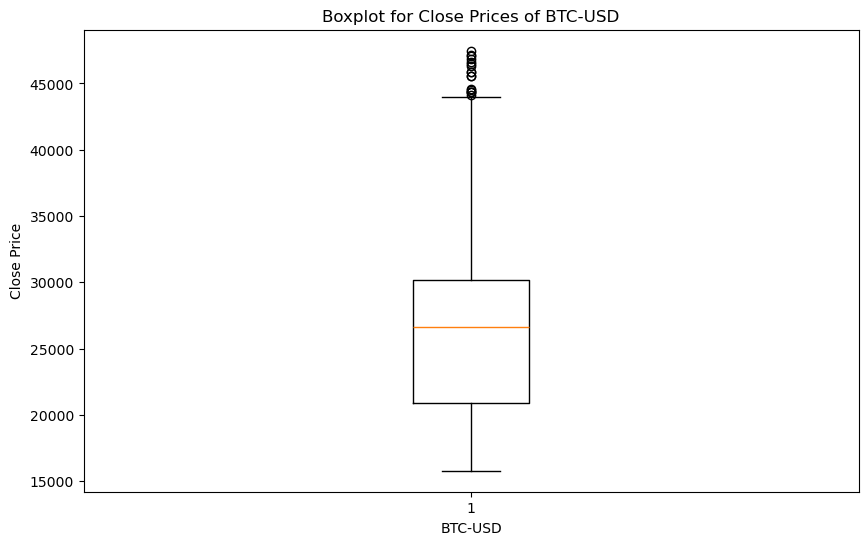


Outliers from boxplot: [45897.57421875 44118.4453125  44338.796875   44575.203125
 44354.63671875 44348.73046875 44500.828125   46820.4921875
 47128.00390625 47465.73046875 47062.6640625  45538.67578125
 46281.64453125 45868.94921875 46453.56640625 46622.67578125
 45555.9921875 ]

Outliers for BTC-USD_close (Manual): Date
2022-01-04    45897.574219
2022-02-08    44118.445312
2022-02-09    44338.796875
2022-02-15    44575.203125
2022-03-01    44354.636719
2022-03-25    44348.730469
2022-03-26    44500.828125
2022-03-27    46820.492188
2022-03-28    47128.003906
2022-03-29    47465.730469
2022-03-30    47062.664062
2022-03-31    45538.675781
2022-04-01    46281.644531
2022-04-02    45868.949219
2022-04-03    46453.566406
2022-04-04    46622.675781
2022-04-05    45555.992188
Name: BTC-USD_close, dtype: float64


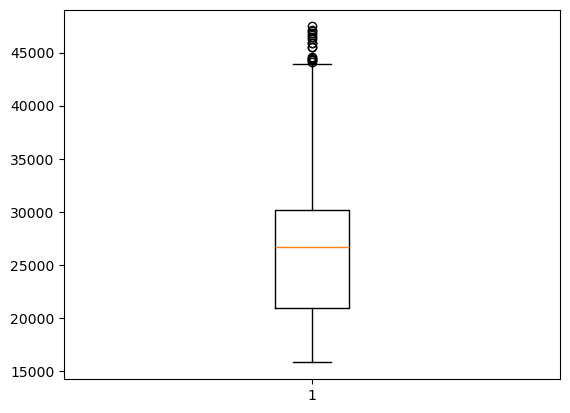

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Filter data for 'close' and 'RoR' (Rate of Return)
close_data = final_df.filter(like='close').copy()
close_data.drop(columns=['BTC-USD_close'], inplace=True)  # Excluding BTC-USD
ror_data = final_df.filter(like='rate')  # Assuming 'rate' is the RoR
# Using Matplotlib plt
# Line Plot for 'close'
plt.figure(figsize=(10, 6))
plt.plot(close_data)
plt.title('Line Plot for Close Prices (Matplotlib)')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend(close_data.columns, loc='upper right')
plt.show()
# Using Seaborn sns
# Boxplot for 'close'
plt.figure(figsize=(12, 8))
sns.boxplot(data=close_data)
plt.title('Boxplot for Close Prices (Seaborn)')
plt.ylabel('Close Price')
plt.show()
# Using Pandas .hist()
# Histogram for comparison with the boxplot results
close_data.hist(bins=50, figsize=(12, 8), alpha=0.5)
plt.suptitle('Histogram for Close Prices')
plt.show()
# Histogram for 'RoR'
ror_data.hist(bins=50, figsize=(12, 8), alpha=0.5)
plt.suptitle('Histogram for Rate of Return (Pandas)')
plt.show()
# Performing outlier detection for BTC-USD using the boxplot
# Create a boxplot
btc_close = final_df.filter(like='BTC-USD')['BTC-USD_close']
plt.figure(figsize=(10, 6))
plt.title('Boxplot for Close Prices of BTC-USD')
plt.boxplot(btc_close)
plt.xlabel('BTC-USD')
plt.ylabel('Close Price')
plt.show()
# Get the outliers
boxplot = plt.boxplot(btc_close)
outliers = boxplot['fliers'][0].get_data()[1]
print("\nOutliers from boxplot:", outliers)
# Identify outliers for BTC-USD_close manually
Q1 = btc_close.quantile(0.25)
Q3 = btc_close.quantile(0.75)
IQR = Q3 - Q1
outliers_manual = btc_close[(btc_close < (Q1 - 1.5 * IQR)) | (btc_close > (Q3 + 1.5 * IQR))]
print("\nOutliers for BTC-USD_close (Manual):", outliers_manual)

### Moving Average in financial analysis

<Axes: xlabel='Date'>

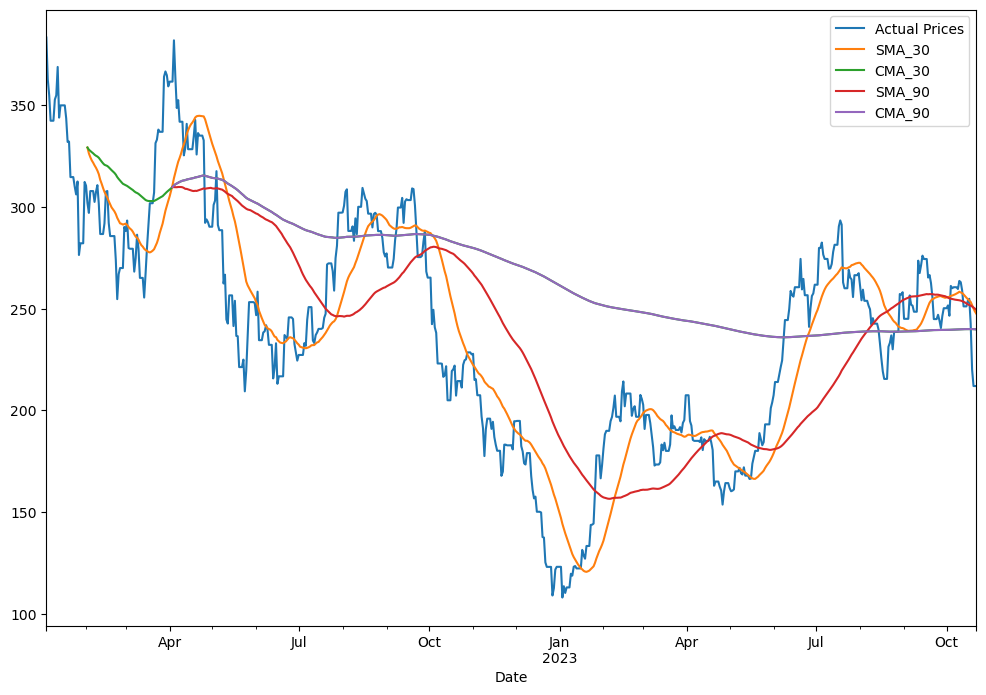

In [175]:
# Select data for TSLA
tsla_close = final_df['TSLA_close']
# Window sizes
windows = [30, 90]
# Initialize an empty DataFrame to store the results
tsla_ma = pd.DataFrame()
tsla_ma['Actual Prices'] = tsla_close
# Calculate and store SMA and CMA for each window size
for window in windows:
    tsla_ma[f'SMA_{window}'] = tsla_close.rolling(window=window).mean()
    tsla_ma[f'CMA_{window}'] = tsla_close.expanding(min_periods=window).mean()
# Display the DataFrame
tsla_ma.plot(figsize=(12, 8))


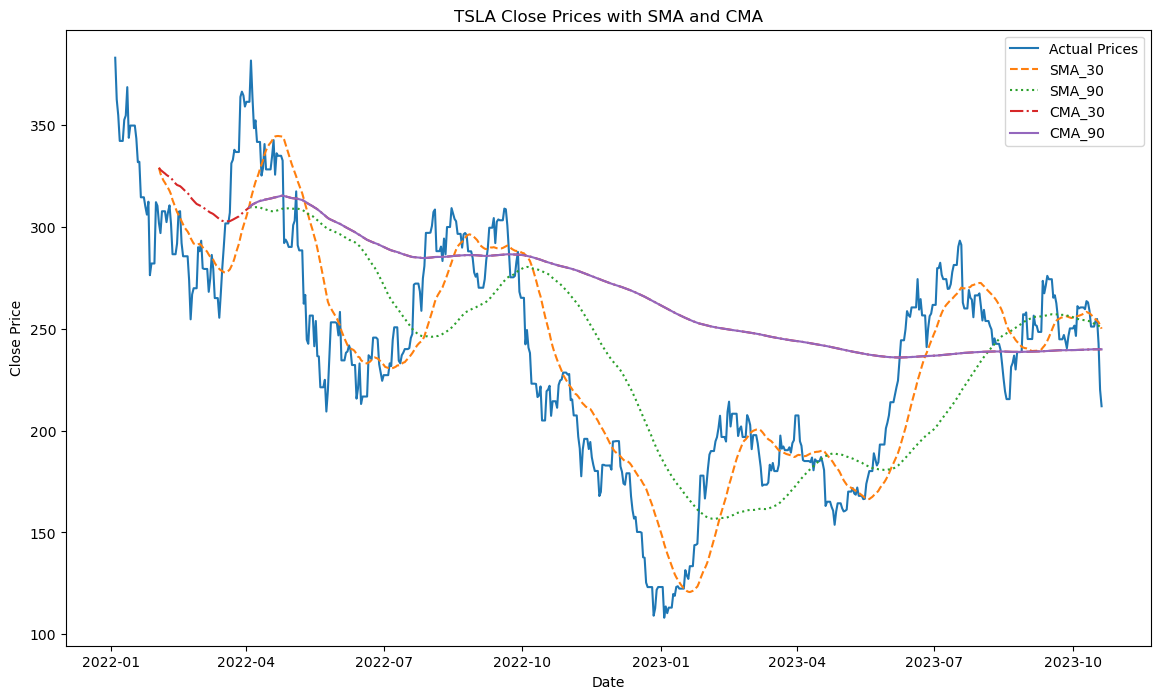

In [176]:
# Change the type of line
# Plotting
plt.figure(figsize=(14, 8))

# Plot actual prices
plt.plot(tsla_moving_averages['Actual Prices'], label='Actual Prices', linestyle='-')

# Plot SMAs
for window in windows:
    if window == 30:
        linestyle = '--'
    else:
        linestyle = ':'
    plt.plot(tsla_moving_averages[f'SMA_{window}'], label=f'SMA_{window}', linestyle=linestyle)

# Plot CMAs
for window in windows:
    if window == 30:
        linestyle = '-.'
    else:
        linestyle = '-'
    plt.plot(tsla_moving_averages[f'CMA_{window}'], label=f'CMA_{window}', linestyle=linestyle)

plt.title('TSLA Close Prices with SMA and CMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

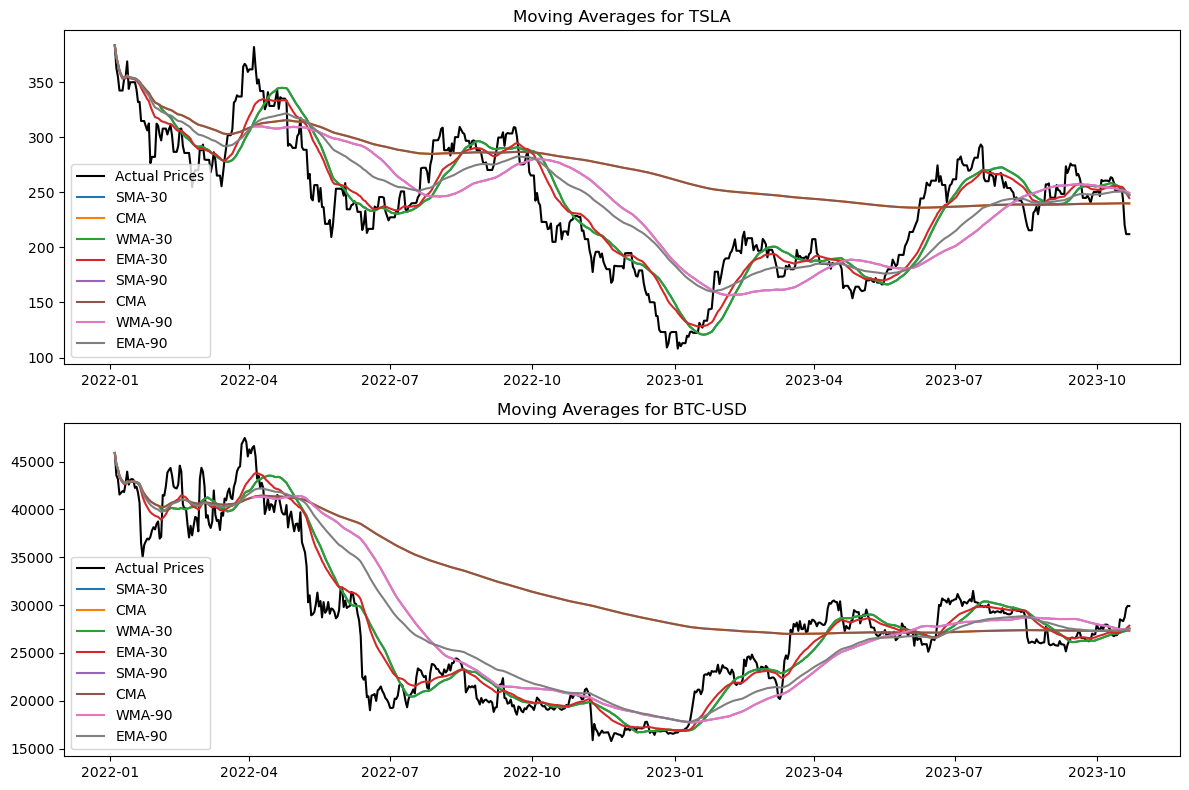

In [177]:
# Assuming final_df is your DataFrame containing the data
# Function to calculate WMA
def weighted_moving_average(series, n, weights=None):
    if weights is None:
        weights = [1]*n
    return series.rolling(n).apply(lambda x: sum(weights*x) / sum(weights), raw=True)

# Select data for TSLA and BTC-USD
tsla_close = final_df['TSLA_close']
btc_close = final_df['BTC-USD_close']

# Window sizes
windows = [30, 90]

# Plotting Moving Averages for TSLA
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.title('Moving Averages for TSLA')
plt.plot(tsla_close, label='Actual Prices', color='black')

for window in windows:
    plt.plot(tsla_close.rolling(window=window).mean(), label=f'SMA-{window}')
    plt.plot(tsla_close.expanding().mean(), label=f'CMA')
    plt.plot(weighted_moving_average(tsla_close, window), label=f'WMA-{window}')
    plt.plot(tsla_close.ewm(span=window).mean(), label=f'EMA-{window}')

plt.legend()

# Plotting Moving Averages for BTC-USD
plt.subplot(2, 1, 2)
plt.title('Moving Averages for BTC-USD')
plt.plot(btc_close, label='Actual Prices', color='black')

for window in windows:
    plt.plot(btc_close.rolling(window=window).mean(), label=f'SMA-{window}')
    plt.plot(btc_close.expanding().mean(), label=f'CMA')
    plt.plot(weighted_moving_average(btc_close, window), label=f'WMA-{window}')
    plt.plot(btc_close.ewm(span=window).mean(), label=f'EMA-{window}')

plt.legend()
plt.tight_layout()
plt.show()


### Basics of Correlation Analysis

Correlation Matrix for Rates:
              BTC-USD_rate  XOM_rate  TSLA_rate  AAPL_rate  AMZN_rate  \
BTC-USD_rate      1.000000  0.153500   0.367552   0.379361   0.398333   
XOM_rate          0.153500  1.000000   0.087812   0.229913   0.152478   
TSLA_rate         0.367552  0.087812   1.000000   0.586555   0.523021   
AAPL_rate         0.379361  0.229913   0.586555   1.000000   0.623741   
AMZN_rate         0.398333  0.152478   0.523021   0.623741   1.000000   
GS_rate           0.264479  0.318666   0.349928   0.508701   0.492348   
JNJ_rate          0.080492  0.095439   0.050447   0.276900   0.161277   

               GS_rate  JNJ_rate  
BTC-USD_rate  0.264479  0.080492  
XOM_rate      0.318666  0.095439  
TSLA_rate     0.349928  0.050447  
AAPL_rate     0.508701  0.276900  
AMZN_rate     0.492348  0.161277  
GS_rate       1.000000  0.258557  
JNJ_rate      0.258557  1.000000  
Displaying scatter plot for TSLA_rate vs AAPL_rate.


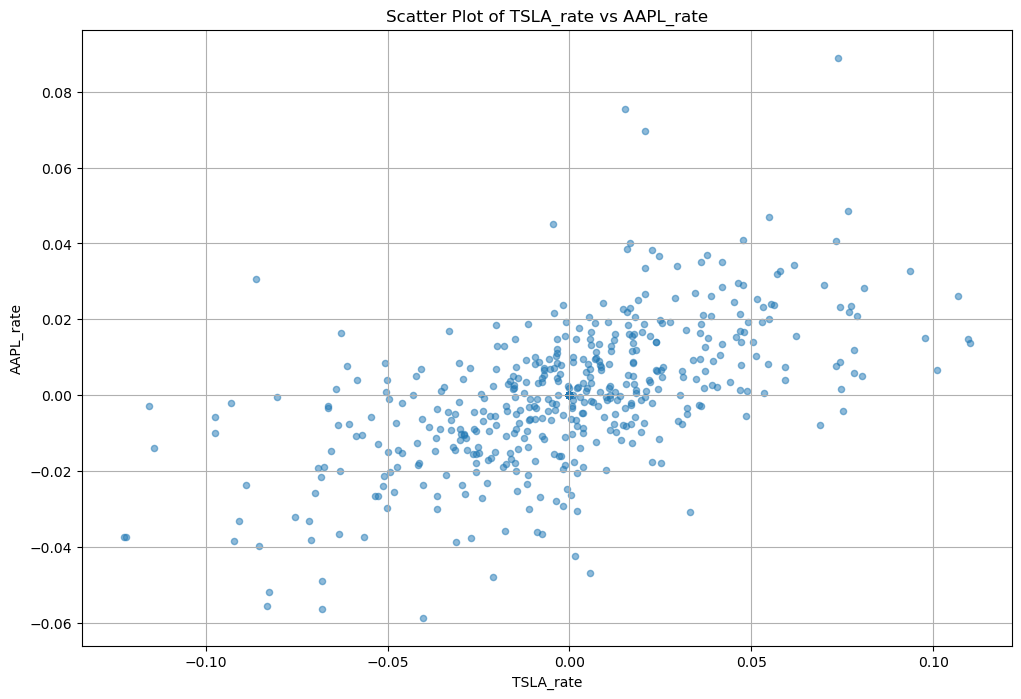

Correlation Matrix for Close Prices:
               XOM_close  TSLA_close  AAPL_close  AMZN_close  GS_close  \
XOM_close       1.000000   -0.700538    0.007879   -0.617589  0.123669   
TSLA_close     -0.700538    1.000000    0.486624    0.881967 -0.069667   
AAPL_close      0.007879    0.486624    1.000000    0.637296  0.059009   
AMZN_close     -0.617589    0.881967    0.637296    1.000000  0.004232   
GS_close        0.123669   -0.069667    0.059009    0.004232  1.000000   
JNJ_close      -0.387851    0.171255   -0.355110    0.083727  0.086328   
BTC-USD_close  -0.569301    0.654409    0.510486    0.770787  0.040164   

               JNJ_close  BTC-USD_close  
XOM_close      -0.387851      -0.569301  
TSLA_close      0.171255       0.654409  
AAPL_close     -0.355110       0.510486  
AMZN_close      0.083727       0.770787  
GS_close        0.086328       0.040164  
JNJ_close       1.000000       0.099054  
BTC-USD_close   0.099054       1.000000  
Displaying scatter plot matrix for

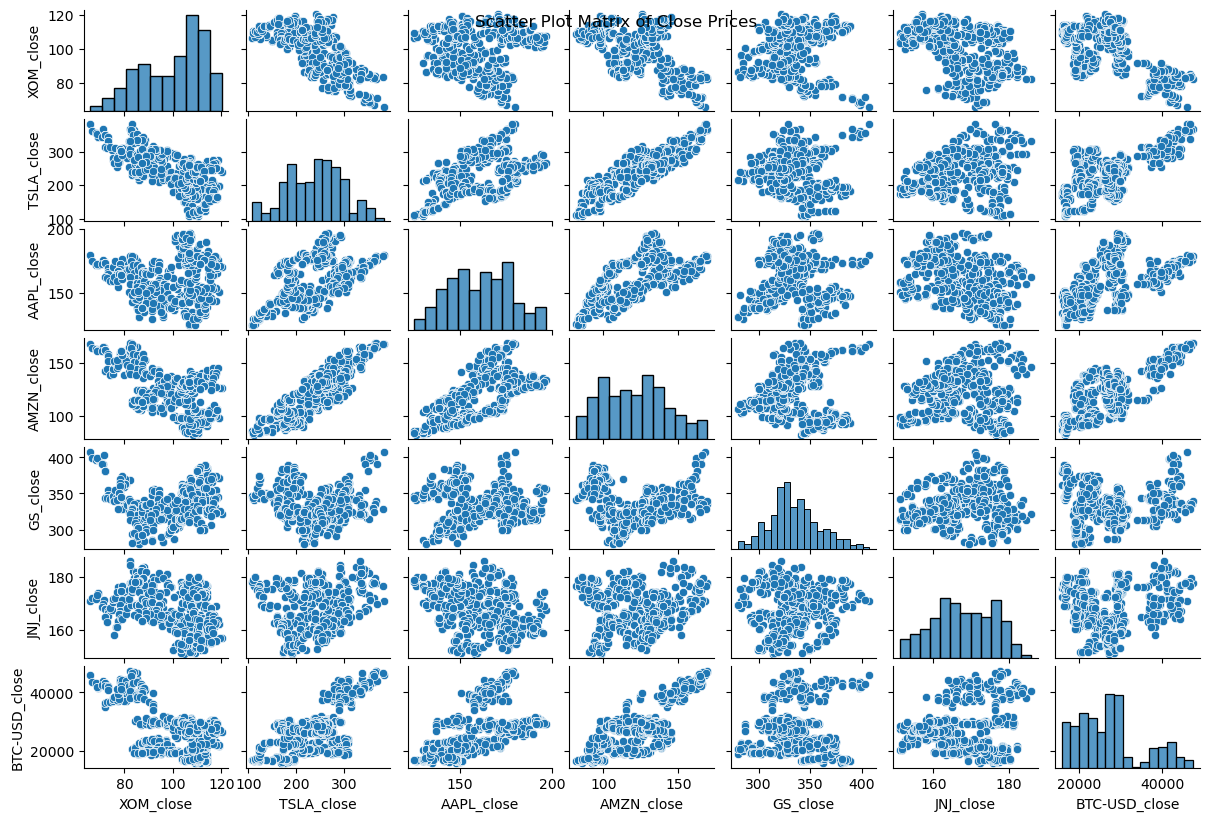

In [178]:
# Correlation matrix for rates
# This will print the correlation matrix for all columns that contain 'rate' in their names.
print("Correlation Matrix for Rates:")
print(final_df.filter(like='rate').corr())
# Scatter plot for TSLA_rate and AAPL_rate
# This will create a scatter plot to visualize the relationship between TSLA_rate and AAPL_rate.
final_df.plot.scatter(x='TSLA_rate', y='AAPL_rate', 
                      figsize=(12, 8), alpha=0.5)
plt.title('Scatter Plot of TSLA_rate vs AAPL_rate')
plt.xlabel('TSLA_rate')
plt.ylabel('AAPL_rate')
plt.grid(True)
print("Displaying scatter plot for TSLA_rate vs AAPL_rate.")
plt.show()
# Correlation matrix for close prices
# This will print the correlation matrix for all columns that contain 'close' in their names.
print("Correlation Matrix for Close Prices:")
print(final_df.filter(like='close').corr())
# Create the pairplot
# This will create a scatter plot matrix (pairplot) for each pair of 'close' columns in the DataFrame.
g = sns.pairplot(final_df.filter(like='close'))
g.figure.set_size_inches(12, 8)
plt.suptitle('Scatter Plot Matrix of Close Prices')
print("Displaying scatter plot matrix for Close Prices.")
plt.show()

## Creating local datasets (optional block) - run it if you do not have the CSV files




In [179]:
STOP

SyntaxError: invalid syntax (1627804089.py, line 1)

In [ ]:
start_date = '2022-01-01'
end_date = '2023-10-21'

In [ ]:
import yfinance as yf
tickers = ['AAPL', 'TSLA', 'AMZN', 'JNJ', 'GS', 'XOM']
df_all = yf.download(tickers=tickers, start = start_date, end = end_date, actions=True)
df_btc = yf.download(tickers='BTC-USD', start = start_date, end = end_date,)
df_btc.to_csv('BTC-USD_ohlc.csv')

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
for t in tickers:
  df = yf.download(tickers=t, start = start_date, end = end_date, actions=True)
  fname = t + '_actions.csv'
  df[['Dividends', 'Stock Splits']].to_csv(fname)
  fname = t + '_ohlc_withSplit.csv'
  df1 = df[['Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'})
  df1.to_csv(fname)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
import pandas_datareader as pdr

for t in tickers[:3]:
  data_av = pdr.get_data_alphavantage(t, api_key='YourAPI', start=start_date,  end = end_date,)
  data_av.index.rename('Date', inplace=True)
  fname = t + '_ohlc.csv'
  data_av.to_csv(fname)
# Pause the execution for 60 seconds (1 minute)
# The standard API call frequency is 5 calls per minute and 100 calls per day
import time
time.sleep(60)

for t in tickers[3:]:
  data_av = pdr.get_data_alphavantage(t, api_key='YourAPI', start=start_date, end = end_date,)
  data_av.index.rename('Date', inplace=True)
  fname = t + '_ohlc.csv'
  data_av.to_csv(fname)

KeyboardInterrupt: 

## &copy; Dr. Dmytro Zherlitsyn, 2023 <br>
## &copy; BPB Publications, 2023